<a href="https://colab.research.google.com/github/Eucalyptusss/NLP_Take_Home_Challenge/blob/main/nlp_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import csv
import numpy as np
from scipy import stats
import os
!pip install colab-env --upgrade
import colab_env
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
#Source on dowloading stopword software
#https://stackoverflow.com/a/47485908/12305091
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
from collections import defaultdict
from collections import Counter
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from io import BytesIO
from zipfile import ZipFile
import urllib.request
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, GRU, SpatialDropout1D
from keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import Precision
from sklearn.metrics import (recall_score, accuracy_score, precision_score, 
                             classification_report, roc_curve, RocCurveDisplay,
                             roc_auc_score, confusion_matrix, plot_confusion_matrix)
from sklearn.utils import class_weight
from keras.datasets import reuters
from tensorflow.keras import layers



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Functions
Below are the functions I will be using for this project.

In [ ]:
def make_predictions(x, model):
  """
  IN:
    x : The data that you would like to make predictions on
    model : The model that you like to use to make the predictions
  OUT:
    y_preds: List containing preictions
  
  """
  y_pred_probs = model.predict(x)
  y_pred = []
  for prob in y_pred_probs:
    if prob < .5:
      y_pred.append(0)
    else:
      y_pred.append(1)
  return y_pred


In [ ]:
# Count unique words
def counter_word(text_):
    count = Counter()
    for i in text_.values:
        for word in i.split():
            count[word] += 1
    return count

In [ ]:
def plot_history(history, style=['ggplot', 'seaborn-talk']):
    """
    SOURCE: Claude Fried (https://www.linkedin.com/in/claude-fried/)
    Plot history from History object (or history dict) 
    once Tensorflow model is trained.
    
    Parameters:
    -----------
    history:
        History object returned from a model.fit()
    style: string or list of strings (default: ['ggplot', 'seaborn-talk'])
        Style from matplotlib.
    """
    
    
    if not isinstance(history, dict):
        history = history.history

    metrics_lst = [m for m in history.keys() if not m.startswith('val')]
    N = len(metrics_lst)
    with plt.style.context(style):
        fig, ax_lst = plt.subplots(nrows=N, figsize=(8, 4*(N)))
        ax_lst = [ax_lst] if N == 1 else ax_lst.flatten() # Flatten ax_lst.
        for metric, ax in zip(metrics_lst, ax_lst):
            val_m = f'val_{metric}'
            ax.plot(history[metric], label=metric)
            ax.plot(history[val_m], label=val_m)
            ax.set(title=metric.title(), xlabel='Epoch', ylabel=metric.title())
            ax.legend()
        fig.tight_layout()
        plt.show()

# Obtain
#### First I will extract the file from the sgm format into a csv format. I have worked with Beutiful Soup prior to this project so I only needed to refresh my memory about it's usage. I used the following documentation https://www.crummy.com/software/BeautifulSoup/bs4/doc/.

## Before running the cell below please double click on the folder Interos_MLAprentice_Application_Welsh folder that I shared and press add shortcut to drive.

In [ ]:
titles = []
texts = []
topics = []

for i in range(21):
  #21 files in the folder
  if len(str(i)) == 1:
    num = '00'+str(i)
  else:
    num = '0'+str(i)
  try:
    soup = BeautifulSoup(open("/content/drive/MyDrive/Interos_MLApprentice_Application_Welsh/reuters_data/reut2-" + num + ".sgm"), features='lxml')
    data_reuters = soup.find_all('reuters')
    for data in data_reuters:
      titles.append(data.find_all('title'))
      texts.append(data.find_all('text'))
      topics.append(data.find_all('topics'))
  except:
    continue  
  


In [ ]:
df = pd.DataFrame(columns=['Title','Text','Topics'])
df.Title = titles
df.Text = texts
df.Topics = topics

In [ ]:
df.shape

(20000, 3)

In [ ]:
df.head()

,Title,Text,Topics
0,[[BAHIA COCOA REVIEW]],"[[\n, [BAHIA COCOA REVIEW], \n, [ SALVADOR,...",[[[cocoa]]]
1,[[STANDARD OIL <SRD> TO FORM FINANCIAL UNIT]],"[[\n, [STANDARD OIL <SRD> TO FORM FINANCIAL UN...",[[]]
2,[[TEXAS COMMERCE BANCSHARES <TCB> FILES PLAN]],"[[\n, [TEXAS COMMERCE BANCSHARES <TCB> FILES P...",[[]]
3,[[TALKING POINT/BANKAMERICA <BAC> EQUITY OFFER]],"[[\n, [TALKING POINT/BANKAMERICA <BAC> EQUITY ...",[[]]
4,[[NATIONAL AVERAGE PRICES FOR FARMER-OWNED RES...,"[[\n, [NATIONAL AVERAGE PRICES FOR FARMER-OWNE...","[[[grain], [wheat], [corn], [barley], [oat], [..."


# Scrub
#### Now I will need to do the following cleaning tasks to prepare for the Natural Language Processing
- Turn each column into a string
- Remove unnecessary characters e.g. theses things []
- Remove rows that do not contain topics
- Reevaluate 


In [ ]:
#First Scrub
#Loop through each column and change the datatype to string
for col in df.columns:
  df[col] = df[col].astype(str)
#Loop through each row of the data frame
for i in range(20_000):
   df.Title[i] = df.Title[i].replace('[','')
   df.Title[i] = df.Title[i].replace(']','')

   df.Text[i] = df.Text[i].replace(df.Title[i], '')

   df.Title[i] = df.Title[i].replace('<title>','')
   df.Title[i] = df.Title[i].replace('</title>','')

   df.Text[i] = df.Text[i].replace('\n', '')
   df.Text[i] = df.Text[i].replace('Reuter</text>]','')
   df.Text[i] = df.Text[i].replace('Reuter</text>]','')
   df.Text[i] = df.Text[i].replace('- </dateline>','')
   df.Text[i] = df.Text[i].replace('[<text><dateline>','')
   df.Text[i] = df.Text[i].replace('  ','')
   df.Text[i] = df.Text[i].replace('</dateline>','')
   df.Text[i] = df.Text[i].replace('</text>]','')

   df.Topics[i] = df.Topics[i].replace('[<topics><d>','')
   df.Topics[i] = df.Topics[i].replace('</d></topics>]','')
   df.Topics[i] = df.Topics[i].replace('</d><d>', '|')
   
#Removes leading and trailing white spaces
df.Text = df.Text.apply(lambda text: text.strip())
#Removes all rows that do not contain topics and resets index
df = df.loc[df.Topics != '[<topics></topics>]'].copy()
df.reset_index(drop=True, inplace=True)

#### Now I will do some Exploratory Data Analysis. The analysis will focus on the text and title columns of the data frame. I will still need to do additional processing to the topic column before I start modeling.

# EDA

#### To ensure an thourough eda process for this project I referenced the following source https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools.

## String Frequencies


 

Text(0.5, 0, 'Number of Characters')

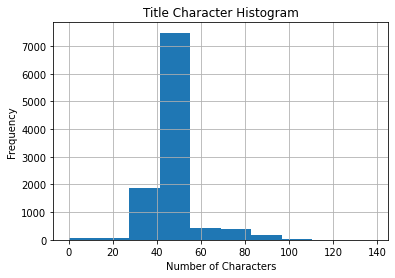

In [ ]:
df.Title.str.len().hist()
plt.title('Title Character Histogram')
plt.ylabel('Frequency')
plt.xlabel('Number of Characters')

There appears to be mostly 40-50 characters per title with some outliers going up to 110.

Text(0.5, 0, 'Number of Characters')

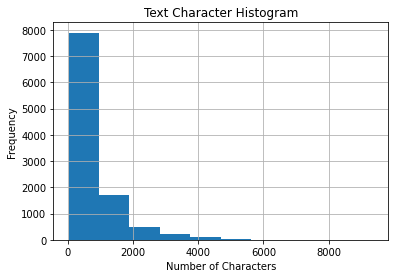

In [ ]:
df.Text.str.len().hist()
plt.title('Text Character Histogram')
plt.ylabel('Frequency')
plt.xlabel('Number of Characters')

There are mostly less than 2000 characters per text. 

Text(0, 0.5, 'Frequency')

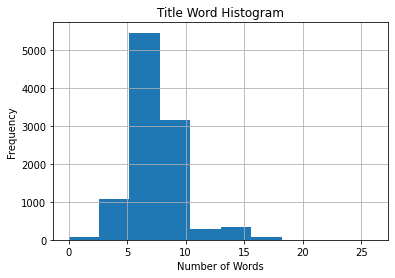

In [ ]:
df.Title.str.split().\
    map(lambda x: len(x)).\
    hist()

plt.title('Title Word Histogram')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

Mostly 5-10 words per title.

Text(0, 0.5, 'Frequency')

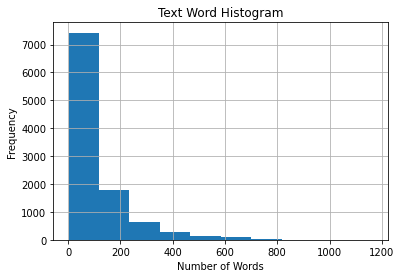

In [ ]:
df.Text.str.split().\
    map(lambda x: len(x)).\
    hist()

plt.title('Text Word Histogram')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

Less than 200 words for most of the texts.

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Frequency')

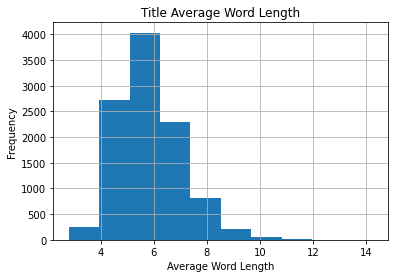

In [ ]:
df.Title.str.split().apply(lambda x: [len(i) for i in x]). \
  map(lambda x: np.mean(x)).hist()
plt.title('Title Average Word Length')
plt.xlabel('Average Word Length')
plt.ylabel('Frequency')

Words are medium sized on average i.e. 6ish characters

Text(0, 0.5, 'Frequency')

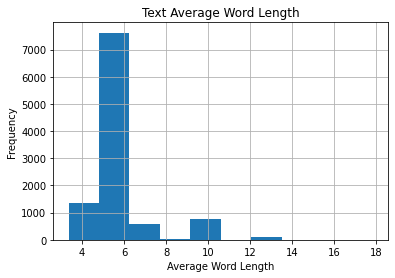

In [ ]:
df.Text.str.split().apply(lambda x: [len(i) for i in x]). \
  map(lambda x: np.mean(x)).hist()
plt.title('Text Average Word Length')
plt.xlabel('Average Word Length')
plt.ylabel('Frequency')

Once again the average words are about 6 characters. There are a signifigant amount of bigger words 12ish characters. This is expected in the text of an article.

## Stopwords

Text(0.5, 0, 'Stop Word')

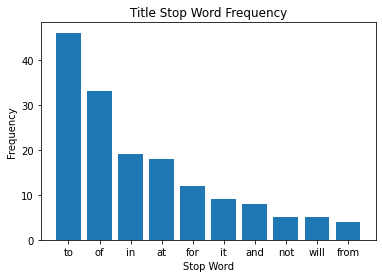

In [ ]:
#Code pulled from 
#https://app.neptune.ai/neptune-ai/eda-nlp-tools/n/1-3-top-stopwords-barchart-b953763c-3fea-4331-bff0-429411793e5f/5c0fca05-ba07-4564-a02e-c44b08bfb8cb
corpus = []
new = df.Title.str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]
dic = defaultdict(int)
for word in corpus:
  if word in stop:
    dic[word] += 1
top = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x, y = zip(*top)
plt.bar(x,y)
plt.title('Title Stop Word Frequency')
plt.ylabel('Frequency')
plt.xlabel('Stop Word')




Standard distribution of stop words.

Text(0, 0.5, 'Word')

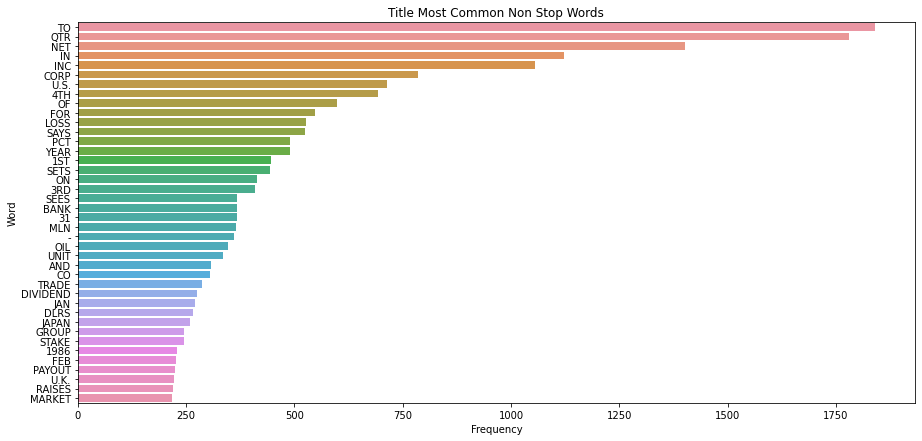

In [ ]:
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)
plt.figure(figsize=(15,7))        
sns.barplot(x=y,y=x)
plt.title('Title Most Common Non Stop Words')
plt.xlabel('Frequency')
plt.ylabel('Word')

Text(0.5, 0, 'Stop Word')

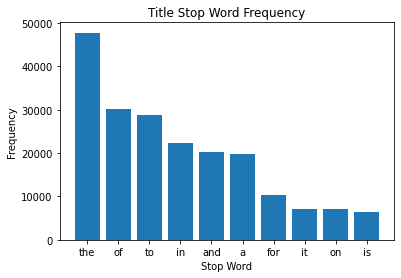

In [ ]:
#Code pulled from 
#https://app.neptune.ai/neptune-ai/eda-nlp-tools/n/1-3-top-stopwords-barchart-b953763c-3fea-4331-bff0-429411793e5f/5c0fca05-ba07-4564-a02e-c44b08bfb8cb
corpus = []
new = df.Text.str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]
dic = defaultdict(int)
for word in corpus:
  if word in stop:
    dic[word] += 1
top = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x, y = zip(*top)
plt.bar(x,y)
plt.title('Title Stop Word Frequency')
plt.ylabel('Frequency')
plt.xlabel('Stop Word')

Text(0, 0.5, 'Word')

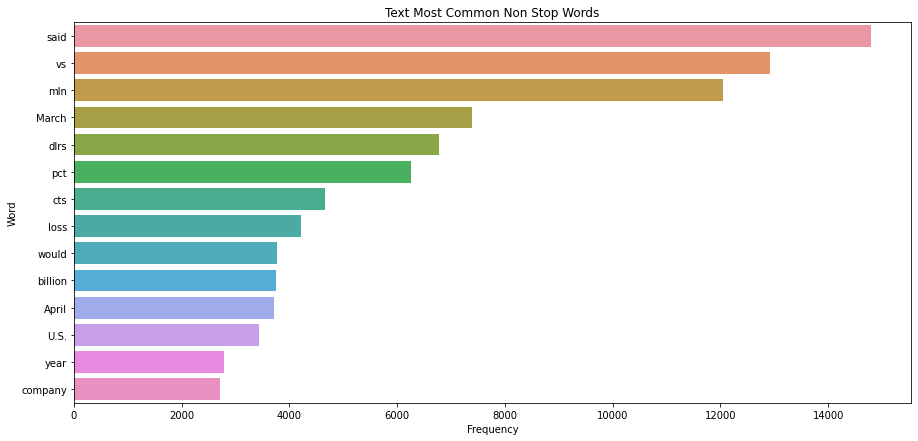

In [ ]:
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
plt.figure(figsize=(15,7))        
sns.barplot(x=y,y=x)
plt.title('Text Most Common Non Stop Words')
plt.xlabel('Frequency')
plt.ylabel('Word')

# Additional Preprocessing
I will take the following steps to prepare the data for modeling & NLP. 
- Decide which topics to classify based on how much data is available 


In [ ]:
df.Topics.value_counts()

earn                                                3746
acq                                                 2147
crude                                                361
trade                                                331
money-fx                                             273
                                                    ... 
livestock|l-cattle|carcass                             1
dlr|yen                                                1
grain|wheat|corn|oat|rye|sorghum|soybean|oilseed       1
crude|gas|fuel                                         1
acq|gold|silver|zinc|lead                              1
Name: Topics, Length: 590, dtype: int64

#### I will do a binary classification task by training the model on earn and acq. My reasoning is that there are too few of the other classes currently. This causes class imbalance which will lead to bias.

In [ ]:
df.Topics.value_counts()[0:2]

earn    3746
acq     2147
Name: Topics, dtype: int64

In [ ]:
df = df.loc[      
             (df.Topics == 'earn') |
             (df.Topics == 'acq') 
            ].copy()

In [ ]:
df.shape

(5893, 3)

In [ ]:
df.head()

,Title,Text,Topics
3,CHAMPION PRODUCTS &lt;CH&gt; APPROVES STOCK SPLIT,"ROCHESTER, N.Y., Feb 26 Champion Products Inc ...",earn
4,COMPUTER TERMINAL SYSTEMS &lt;CPML&gt; COMPLET...,"COMMACK, N.Y., Feb 26 Computer Terminal System...",acq
5,COBANCO INC &lt;CBCO&gt; YEAR NET,"SANTA CRUZ, Calif., Feb 26 -Shr 34 cts vs 1.19...",earn
7,AM INTERNATIONAL INC &lt;AM&gt; 2ND QTR JAN 31,"CHICAGO, Feb 26 -Oper shr loss two cts vs prof...",earn
8,BROWN-FORMAN INC &lt;BFD&gt; 4TH QTR NET,"LOUISVILLE, Ky., Feb 26 -Shr one dlr vs 73 cts...",earn


In [ ]:
df['combined_text'] = df.Title + df.Text

In [ ]:
text_ = df.combined_text
counter = counter_word(text_)
num_words = len(counter)
max_length = 200

# Categorical Encoding


In [ ]:
df.Topics.value_counts()

earn    3746
acq     2147
Name: Topics, dtype: int64

In [ ]:
y = df.Topics.apply(lambda label:
                    1 if label =='earn'
                    else(0))

print('Shape of label tensor:', y.shape)

Shape of label tensor: (5893,)


In [ ]:
y.value_counts()

1    3746
0    2147
Name: Topics, dtype: int64

# Train Test Split

In [ ]:
seed = 24

X = df['combined_text']
#Test size is 15% of total data
test_size = int(np.round(X.shape[0] * .15))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, 
                                                    random_state=seed, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=test_size, random_state=seed, stratify=y_train)

print(f'Train:\n\tX: {X_train.shape}\n\ty: {y_train.shape}')
print(f'Test:\n\tX: {X_test.shape}\n\ty: {y_test.shape}')
print(f'Val:\n\tX: {X_val.shape}\n\ty: {y_val.shape}')

Train:
	X: (4125,)
	y: (4125,)
Test:
	X: (884,)
	y: (884,)
Val:
	X: (884,)
	y: (884,)


# NLP

In [ ]:
#TOKENIZE
#Removes Puncuation, and lowercases 
tokenizer = Tokenizer(num_words=num_words, 
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
#Sequencing
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(
    train_sequences, maxlen=max_length, padding="post", truncating="post"
)
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(
    test_sequences, maxlen=max_length, padding="post", truncating="post"
)
val_sequences = tokenizer.texts_to_sequences(X_val)
val_padded = pad_sequences(
    val_sequences, maxlen=max_length, padding="post", truncating="post"
)

Now I will add word embedding using the infamous GloVe model found here (https://nlp.stanford.edu/projects/glove/)

## GloVe


In [ ]:
glove_vecs = {}
#To unzip the file I used the following code:
#https://stackoverflow.com/a/42119017/12305091

url = urllib.request.urlopen("https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip")

with ZipFile(BytesIO(url.read())) as my_zip_file:
    for line in my_zip_file.open(my_zip_file.namelist()[0]).readlines(): 
            values = line.split()
            word = str(values[0])[1:]
            word = word[1:]
            word = word[:-1]
            vectors = np.asarray(values[1:])
            glove_vecs[word] = vectors
word_vector_matrix = np.zeros((num_words, 100))
vec_size = 100


In [ ]:
#Adds word embeddings to words within the word_index
for word, idx in tokenizer.word_index.items():
  vector = glove_vecs.get(word)
  #Only adding to word_vector_matrix if word is in glove_vecs
  if vector is not None:
    word_vector_matrix[idx] = vector

## Class Imbalance
There are many more labels of type 'earn'. This will lead to model bias, so I will add class weights to the neural network. To start I will use sklearn generated weights.

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(df.Topics), df.Topics)                                              

In [ ]:
class_weights

array([1.37238007, 0.78657234])

In [ ]:
weights = {
    0: class_weights[0],
    1: class_weights[1],
}

In [ ]:
len(glove_vecs.keys())

400001

# Modeling
#### After doing the process below nine times I have determined that I needed to undersample the majority class earn. Now, I will repeat this process for the newly distributed data.
#### To determine the strongest model I will need to first determine proper weights. As it is now, the model will likely predict the majority/minority class until I determine the best class weights.

In [ ]:
weights

{0: 1.139496972519795, 1: 0.8909322651128915}

In [ ]:
model_one = Sequential()
model_one.add(Embedding(num_words, vec_size, input_length=max_length,
                        weights = [word_vector_matrix], trainable = False))
model_one.add(LSTM(100))
model_one.add(Dense(1, activation='sigmoid'))
opt = Adam(learning_rate=3e-4)
model_one.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']
              )

epochs = 50
batch_size = 100

In [ ]:
history_one = model_one.fit(train_padded, np.array(y_train), epochs=epochs, batch_size=batch_size,
                    validation_split=0.1, validation_data=(test_padded, y_test),
                    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)], 
              class_weight=weights
                     ) 

Epoch 1/50
31/31 [==============================] - 4s 60ms/step - loss: 0.6863 - accuracy: 0.4864 - val_loss: 0.6772 - val_accuracy: 0.6035
Epoch 2/50
31/31 [==============================] - 1s 40ms/step - loss: 0.6777 - accuracy: 0.6003 - val_loss: 0.6647 - val_accuracy: 0.6239
Epoch 3/50
31/31 [==============================] - 1s 39ms/step - loss: 0.5813 - accuracy: 0.7210 - val_loss: 0.6628 - val_accuracy: 0.6676
Epoch 4/50
31/31 [==============================] - 1s 38ms/step - loss: 0.5904 - accuracy: 0.7713 - val_loss: 1.3667 - val_accuracy: 0.5102
Epoch 5/50
31/31 [==============================] - 1s 39ms/step - loss: 1.0288 - accuracy: 0.4455 - val_loss: 0.8027 - val_accuracy: 0.4402
Epoch 6/50
31/31 [==============================] - 1s 39ms/step - loss: 0.7002 - accuracy: 0.4689 - val_loss: 0.6780 - val_accuracy: 0.6006
Epoch 7/50
31/31 [==============================] - 1s 39ms/step - loss: 0.6847 - accuracy: 0.5892 - val_loss: 0.6775 - val_accuracy: 0.6006
Epoch 8/50
31

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          7912700   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 7,993,201
Trainable params: 80,501
Non-trainable params: 7,912,700
_________________________________________________________________
None


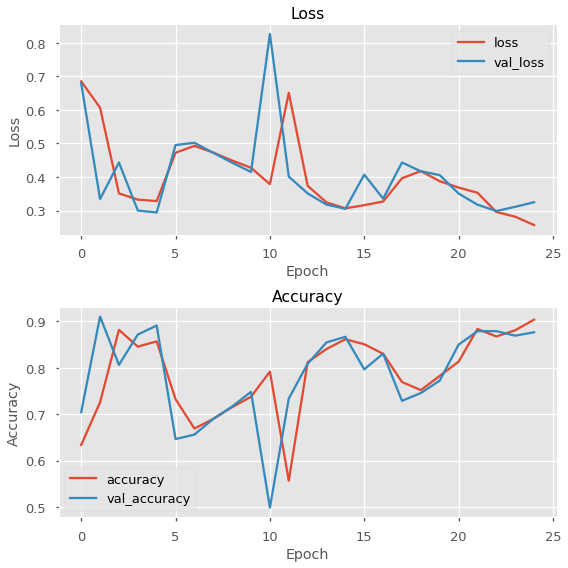

              precision    recall  f1-score   support

           0       0.83      0.93      0.88       322
           1       0.95      0.90      0.92       562

    accuracy                           0.91       884
   macro avg       0.89      0.91      0.90       884
weighted avg       0.91      0.91      0.91       884



In [ ]:
print(model_one.summary())
plot_history(history_one)
y_pred = make_predictions(val_padded, model_one)
print(classification_report(y_val, y_pred))

#### The model performed well! I will define this model as my baseline model and compare further models to the classification report above.

In [ ]:
weights

{0: 1.039496972519795, 1: 0.8909322651128915}

In [ ]:
model_two = Sequential()
model_two.add(Embedding(num_words, vec_size, input_length=max_length,
                        weights = [word_vector_matrix], trainable = False))
model_two.add(SpatialDropout1D(0.2))
model_two.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
model_two.add(Dense(1, activation='sigmoid'))
model_two.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 100

history_two = model_two.fit(train_padded, y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1, validation_data=(test_padded, y_test),
                    callbacks=[EarlyStopping( patience=5, min_delta=0.0001)], 
                    class_weight=weights)

Epoch 1/10
31/31 [==============================] - 34s 961ms/step - loss: 0.6933 - accuracy: 0.4672 - val_loss: 0.6937 - val_accuracy: 0.4402
Epoch 2/10
31/31 [==============================] - 30s 968ms/step - loss: 0.6932 - accuracy: 0.4578 - val_loss: 0.6934 - val_accuracy: 0.4402
Epoch 3/10
31/31 [==============================] - 30s 961ms/step - loss: 0.6933 - accuracy: 0.5318 - val_loss: 0.6935 - val_accuracy: 0.4402
Epoch 4/10
31/31 [==============================] - 29s 946ms/step - loss: 0.6932 - accuracy: 0.4387 - val_loss: 0.6937 - val_accuracy: 0.4402
Epoch 5/10
31/31 [==============================] - 29s 923ms/step - loss: 0.6932 - accuracy: 0.5172 - val_loss: 0.6924 - val_accuracy: 0.5598
Epoch 6/10
31/31 [==============================] - 29s 942ms/step - loss: 0.6932 - accuracy: 0.5607 - val_loss: 0.6927 - val_accuracy: 0.5598
Epoch 7/10
31/31 [==============================] - 29s 919ms/step - loss: 0.6932 - accuracy: 0.4594 - val_loss: 0.6934 - val_accuracy: 0.4402

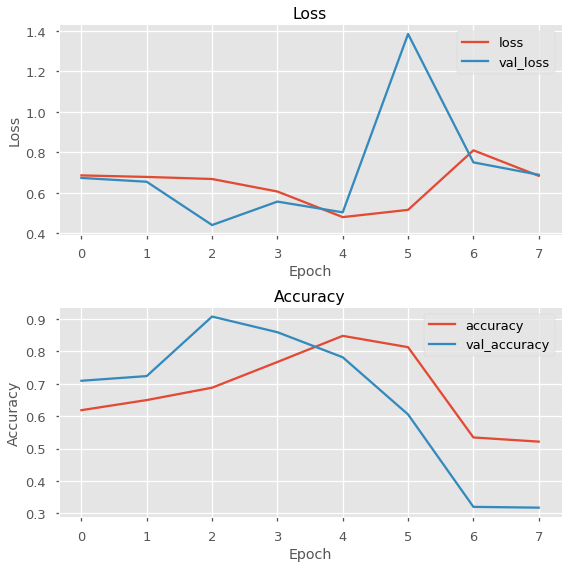

              precision    recall  f1-score   support

           0       0.36      0.98      0.53       322
           1       0.55      0.01      0.02       562

    accuracy                           0.37       884
   macro avg       0.45      0.50      0.28       884
weighted avg       0.48      0.37      0.21       884



In [ ]:
plot_history(history_two)
y_pred = make_predictions(val_padded, model_two)
print(classification_report(y_val, y_pred))

#### Model two performed worse on all metrics. There was not evidence that the model was strongly overfitting so I will remove the dropout layers.

In [ ]:
weights

{0: 1.372380065207266, 1: 0.5365723438334222}

In [ ]:
model_three = Sequential()
model_three.add(Embedding(num_words, vec_size, input_length=max_length))
model_three.add(GRU(100)
model_three.add(Dense(1, activation='sigmoid'))
model_three.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs =50
batch_size = 100

history_three = model_three.fit(train_padded, y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1, validation_data=(test_padded, y_test),
                    callbacks=[EarlyStopping( patience=15, min_delta=0.0001)], 
                    class_weight=weights)

Epoch 1/10
38/38 [==============================] - 81s 2s/step - loss: 0.6502 - accuracy: 0.3758 - val_loss: 0.7097 - val_accuracy: 0.3075
Epoch 2/10
38/38 [==============================] - 78s 2s/step - loss: 0.6496 - accuracy: 0.3707 - val_loss: 0.6984 - val_accuracy: 0.3075
Epoch 3/10
38/38 [==============================] - 78s 2s/step - loss: 0.6506 - accuracy: 0.4502 - val_loss: 0.7468 - val_accuracy: 0.3075
Epoch 4/10
38/38 [==============================] - 78s 2s/step - loss: 0.6493 - accuracy: 0.3707 - val_loss: 0.7274 - val_accuracy: 0.3075
Epoch 5/10
38/38 [==============================] - 79s 2s/step - loss: 0.6489 - accuracy: 0.3707 - val_loss: 0.7273 - val_accuracy: 0.3075
Epoch 6/10
38/38 [==============================] - 79s 2s/step - loss: 0.6496 - accuracy: 0.3707 - val_loss: 0.7341 - val_accuracy: 0.3075
Epoch 7/10
38/38 [==============================] - 79s 2s/step - loss: 0.6493 - accuracy: 0.3707 - val_loss: 0.7233 - val_accuracy: 0.3075


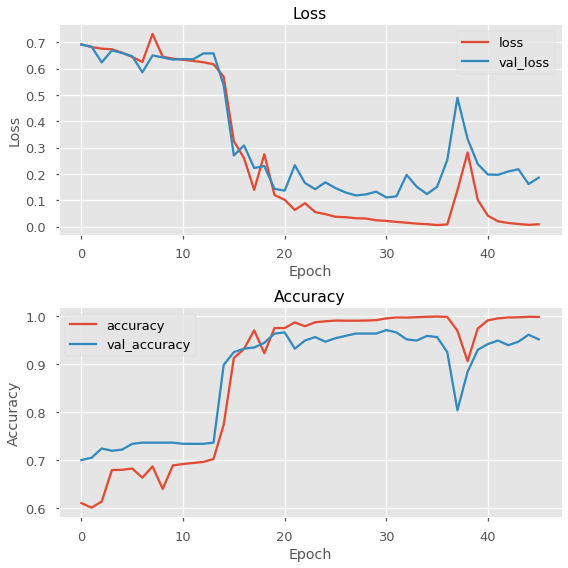

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       322
           1       0.95      0.93      0.94       562

    accuracy                           0.93       884
   macro avg       0.92      0.92      0.92       884
weighted avg       0.93      0.93      0.93       884



In [ ]:
plot_history(history_three)
y_pred = make_predictions(val_padded, model_three)
print(classification_report(y_val, y_pred))

#### Model Three is comprable to the baseline model.
#### Baseline Model

           precision    recall  f1-score   support

           0       0.83      0.93      0.88       322
           1       0.95      0.90      0.92       562

    accuracy                           0.91       884

#### Model Three
          precision    recall  f1-score   support

           0       0.88      0.92      0.90       322
           1       0.95      0.93      0.94       562

    accuracy                           0.93       884

### I have determined model three to be the stronger model based on the following observations:       
- Model Three Minority Class (acq) has a higher precision by .5
- Model Three Majority Class (earn) has a higher recall by .3
- Model Three total accuraacy is higher by .2

- Baseline Model minority class (acq) has a higher recall by .1


In [ ]:
model_four = Sequential()
model_four.add(Embedding(num_words, vec_size, input_length=max_length))
model_four.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
model_four.add(Dense(1, activation='sigmoid'))
model_four.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 20
batch_size = 100

history_four = model_four.fit(train_padded, y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1, validation_data=(test_padded, y_test),
                    callbacks=[EarlyStopping(patience=7, min_delta=0.0001)], 
                    class_weight=weights)

Epoch 1/20
38/38 [==============================] - 44s 1s/step - loss: 0.6947 - accuracy: 0.5310 - val_loss: 0.7081 - val_accuracy: 0.3075
Epoch 2/20
38/38 [==============================] - 40s 1s/step - loss: 0.6868 - accuracy: 0.5851 - val_loss: 0.6676 - val_accuracy: 0.7046
Epoch 3/20
38/38 [==============================] - 40s 1s/step - loss: 0.6707 - accuracy: 0.5994 - val_loss: 0.7056 - val_accuracy: 0.3245
Epoch 4/20
38/38 [==============================] - 39s 1s/step - loss: 0.6630 - accuracy: 0.5814 - val_loss: 0.6267 - val_accuracy: 0.7167
Epoch 5/20
38/38 [==============================] - 40s 1s/step - loss: 0.6668 - accuracy: 0.6705 - val_loss: 0.6778 - val_accuracy: 0.7240
Epoch 6/20
38/38 [==============================] - 40s 1s/step - loss: 0.6490 - accuracy: 0.6746 - val_loss: 0.6666 - val_accuracy: 0.7312
Epoch 7/20
38/38 [==============================] - 39s 1s/step - loss: 0.6332 - accuracy: 0.5560 - val_loss: 0.6624 - val_accuracy: 0.7530
Epoch 8/20
38/38 [==

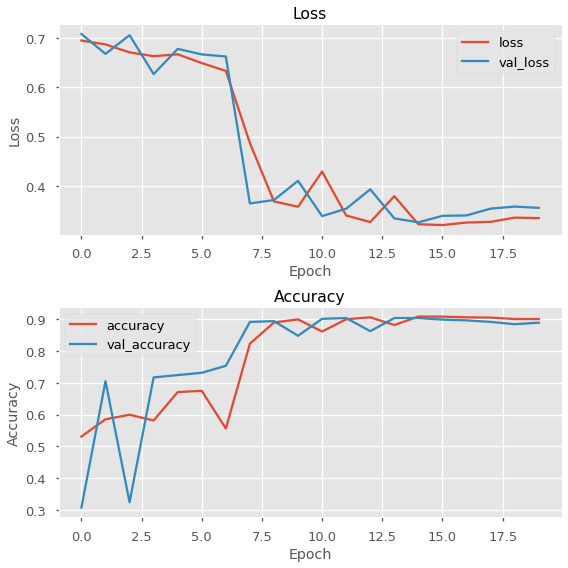

              precision    recall  f1-score   support

           0       0.93      0.61      0.74       322
           1       0.82      0.98      0.89       562

    accuracy                           0.84       884
   macro avg       0.87      0.79      0.81       884
weighted avg       0.86      0.84      0.83       884



In [ ]:
plot_history(history_four)
y_pred = make_predictions(val_padded, model_four)
print(classification_report(y_val, y_pred))

#### Model Three is still the best performing model.

In [ ]:
model_five = Sequential()
model_five.add(Embedding(num_words, vec_size, input_length=max_length,
                    weights = [word_vector_matrix], trainable = False))

model_five.add(GRU(64, kernel_regularizer=regularizers.l2()))

model_five.add(Dense(128, activation='tanh'))
model_five.add(Dense(1, activation="sigmoid"))
optimizer = Adam(learning_rate=3e-4)
model_five.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
epochs = 100
batch_size = 100

history_five = model_five.fit(train_padded, y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1, validation_data=(test_padded, y_test),
                    callbacks=[EarlyStopping(patience=25, min_delta=0.0001)], 
                    class_weight=weights)

Epoch 1/100
38/38 [==============================] - 4s 57ms/step - loss: 1.8683 - accuracy: 0.6325 - val_loss: 1.7292 - val_accuracy: 0.7070
Epoch 2/100
38/38 [==============================] - 2s 44ms/step - loss: 1.6107 - accuracy: 0.6422 - val_loss: 1.4876 - val_accuracy: 0.7046
Epoch 3/100
38/38 [==============================] - 2s 44ms/step - loss: 1.4067 - accuracy: 0.6433 - val_loss: 1.3091 - val_accuracy: 0.7070
Epoch 4/100
38/38 [==============================] - 2s 44ms/step - loss: 1.2450 - accuracy: 0.6463 - val_loss: 1.1662 - val_accuracy: 0.7094
Epoch 5/100
38/38 [==============================] - 2s 44ms/step - loss: 1.1162 - accuracy: 0.6492 - val_loss: 1.0579 - val_accuracy: 0.7167
Epoch 6/100
38/38 [==============================] - 2s 45ms/step - loss: 1.0155 - accuracy: 0.6509 - val_loss: 0.9679 - val_accuracy: 0.7191
Epoch 7/100
38/38 [==============================] - 2s 44ms/step - loss: 0.9334 - accuracy: 0.4817 - val_loss: 0.8738 - val_accuracy: 0.7361
Epoch 

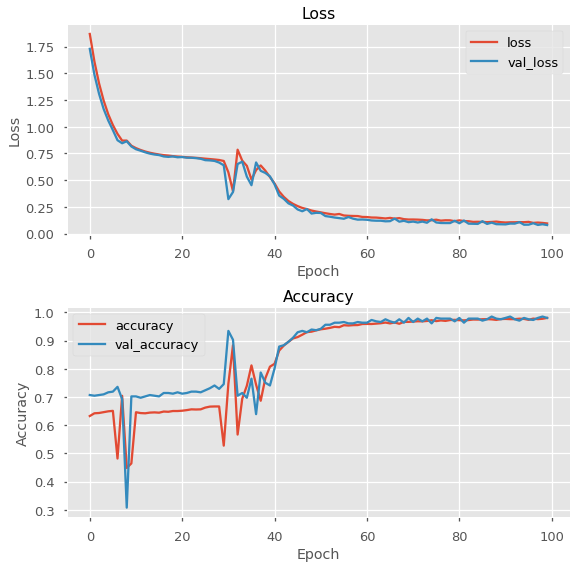

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       322
           1       0.99      0.97      0.98       562

    accuracy                           0.97       884
   macro avg       0.97      0.97      0.97       884
weighted avg       0.97      0.97      0.97       884



In [ ]:
plot_history(history_five)
y_pred = make_predictions(val_padded, model_five)
print(classification_report(y_val, y_pred))

#### It appears that Model five is the best performing model. I will compare the classification reports.

#### Model Three

precision    recall  f1-score   support

       0       0.88      0.92      0.90       322
       1       0.95      0.93      0.94       562

    accuracy                           0.93       884

#### Model Five

           precision    recall  f1-score   support

           0       0.95      0.98      0.96       322
           1       0.99      0.97      0.98       562

    accuracy                           0.97       884  

#### Model Five is stronger on all metrics. At this point, I will consider this my final model but will continue to look for possible optimizations. To start I will compare three versions of batch size.

In [ ]:
model_v1 = Sequential()
model_v1.add(Embedding(num_words, vec_size, input_length=max_length,
                    weights = [word_vector_matrix], trainable = False))

model_v1.add(GRU(64, kernel_regularizer=regularizers.l2()))

model_v1.add(Dense(128, activation='tanh'))
model_v1.add(Dense(1, activation="sigmoid"))
optimizer = Adam(learning_rate=3e-4)
model_v1.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
epochs = 200
batch_size = 50

history_v1 = model_v1.fit(train_padded, y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1, validation_data=(test_padded, y_test),
                    callbacks=[EarlyStopping(patience=25, min_delta=0.0001,
                    restore_best_weights=True)], class_weight=weights)

Epoch 1/200
75/75 [==============================] - 12s 127ms/step - loss: 1.7399 - accuracy: 0.5361 - val_loss: 1.5017 - val_accuracy: 0.7070
Epoch 2/200
75/75 [==============================] - 9s 120ms/step - loss: 1.3352 - accuracy: 0.6436 - val_loss: 1.1827 - val_accuracy: 0.7094
Epoch 3/200
75/75 [==============================] - 9s 121ms/step - loss: 1.0795 - accuracy: 0.6457 - val_loss: 0.9830 - val_accuracy: 0.7167
Epoch 4/200
75/75 [==============================] - 9s 122ms/step - loss: 0.9191 - accuracy: 0.6490 - val_loss: 0.8506 - val_accuracy: 0.7191
Epoch 5/200
75/75 [==============================] - 9s 123ms/step - loss: 0.8172 - accuracy: 0.6385 - val_loss: 0.7509 - val_accuracy: 0.7312
Epoch 6/200
75/75 [==============================] - 9s 120ms/step - loss: 0.7565 - accuracy: 0.5973 - val_loss: 0.6995 - val_accuracy: 0.6925
Epoch 7/200
75/75 [==============================] - 9s 119ms/step - loss: 0.7194 - accuracy: 0.5857 - val_loss: 0.5398 - val_accuracy: 0.724

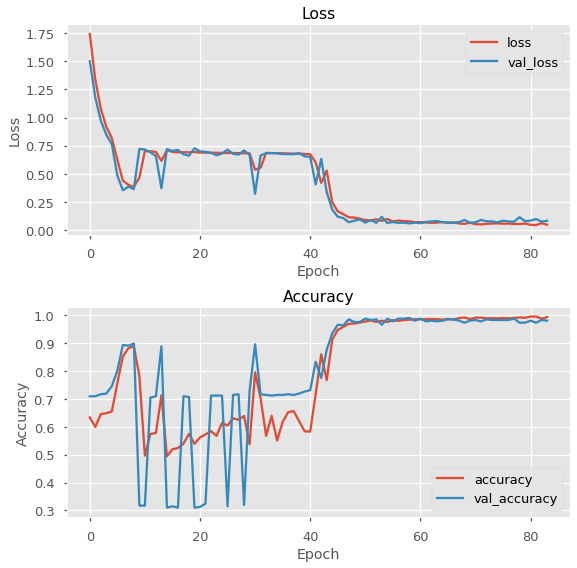

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       322
           1       0.97      0.98      0.98       562

    accuracy                           0.97       884
   macro avg       0.97      0.97      0.97       884
weighted avg       0.97      0.97      0.97       884



In [ ]:
plot_history(history_v1)
y_pred = make_predictions(val_padded, model_v1)
print(classification_report(y_val, y_pred))

In [ ]:
model_v2 = Sequential()
model_v2.add(Embedding(num_words, vec_size, input_length=max_length,
                    weights = [word_vector_matrix], trainable = False))

model_v2.add(GRU(64, kernel_regularizer=regularizers.l2()))

model_v2.add(Dense(128, activation='tanh'))
model_v2.add(Dense(1, activation="sigmoid"))
optimizer = Adam(learning_rate=3e-4)
model_v2.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
epochs = 200
batch_size = 150

history_v2 = model_v2.fit(train_padded, y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1, validation_data=(test_padded, y_test),
                    callbacks=[EarlyStopping(patience=25, min_delta=0.0001)], 
                    class_weight=weights)

Epoch 1/200
25/25 [==============================] - 4s 64ms/step - loss: 1.9258 - accuracy: 0.6250 - val_loss: 1.8331 - val_accuracy: 0.6998
Epoch 2/200
25/25 [==============================] - 1s 44ms/step - loss: 1.7435 - accuracy: 0.6420 - val_loss: 1.6564 - val_accuracy: 0.7070
Epoch 3/200
25/25 [==============================] - 1s 42ms/step - loss: 1.5853 - accuracy: 0.6439 - val_loss: 1.5033 - val_accuracy: 0.7070
Epoch 4/200
25/25 [==============================] - 1s 41ms/step - loss: 1.4493 - accuracy: 0.6455 - val_loss: 1.3809 - val_accuracy: 0.7119
Epoch 5/200
25/25 [==============================] - 1s 40ms/step - loss: 1.3321 - accuracy: 0.6466 - val_loss: 1.2709 - val_accuracy: 0.7119
Epoch 6/200
25/25 [==============================] - 1s 40ms/step - loss: 1.2309 - accuracy: 0.6495 - val_loss: 1.1780 - val_accuracy: 0.7143
Epoch 7/200
25/25 [==============================] - 1s 40ms/step - loss: 1.1439 - accuracy: 0.6546 - val_loss: 1.0894 - val_accuracy: 0.7215
Epoch 

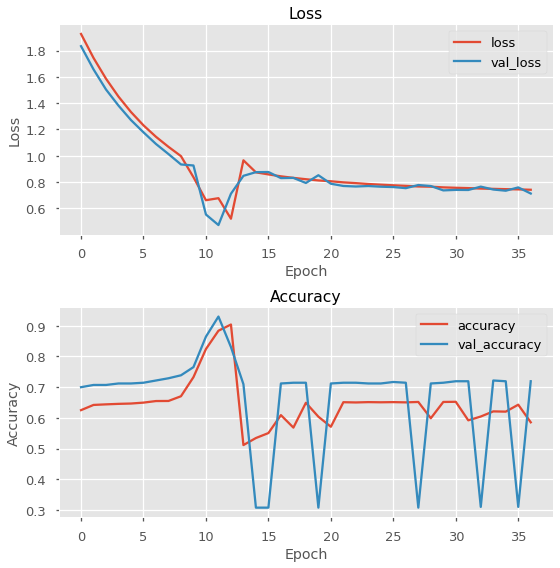

              precision    recall  f1-score   support

           0       0.62      0.16      0.25       322
           1       0.66      0.94      0.78       562

    accuracy                           0.66       884
   macro avg       0.64      0.55      0.51       884
weighted avg       0.65      0.66      0.59       884



In [ ]:
plot_history(history_v2)
y_pred = make_predictions(val_padded, model_v2)
print(classification_report(y_val, y_pred))

In [ ]:
model_v3 = Sequential()
model_v3.add(Embedding(num_words, vec_size, input_length=max_length,
                    weights = [word_vector_matrix], trainable = False))

model_v3.add(GRU(64, kernel_regularizer=regularizers.l2()))

model_v3.add(Dense(128, activation='tanh'))
model_v3.add(Dense(1, activation="sigmoid"))
optimizer = Adam(learning_rate=3e-4)
model_v3.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
epochs = 200
batch_size = 200

history_v3 = model_v3.fit(train_padded, y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1, validation_data=(test_padded, y_test),
                    callbacks=[EarlyStopping(patience=25, min_delta=0.0001)], 
                    class_weight=weights)

Epoch 1/200
19/19 [==============================] - 3s 75ms/step - loss: 1.9567 - accuracy: 0.6250 - val_loss: 1.8809 - val_accuracy: 0.7046
Epoch 2/200
19/19 [==============================] - 1s 42ms/step - loss: 1.8101 - accuracy: 0.6412 - val_loss: 1.7366 - val_accuracy: 0.7070
Epoch 3/200
19/19 [==============================] - 1s 39ms/step - loss: 1.6794 - accuracy: 0.6425 - val_loss: 1.6110 - val_accuracy: 0.7094
Epoch 4/200
19/19 [==============================] - 1s 38ms/step - loss: 1.5631 - accuracy: 0.6439 - val_loss: 1.5002 - val_accuracy: 0.7094
Epoch 5/200
19/19 [==============================] - 1s 37ms/step - loss: 1.4593 - accuracy: 0.6441 - val_loss: 1.4029 - val_accuracy: 0.7094
Epoch 6/200
19/19 [==============================] - 1s 36ms/step - loss: 1.3669 - accuracy: 0.6447 - val_loss: 1.3156 - val_accuracy: 0.7119
Epoch 7/200
19/19 [==============================] - 1s 35ms/step - loss: 1.2842 - accuracy: 0.6468 - val_loss: 1.2390 - val_accuracy: 0.7094
Epoch 

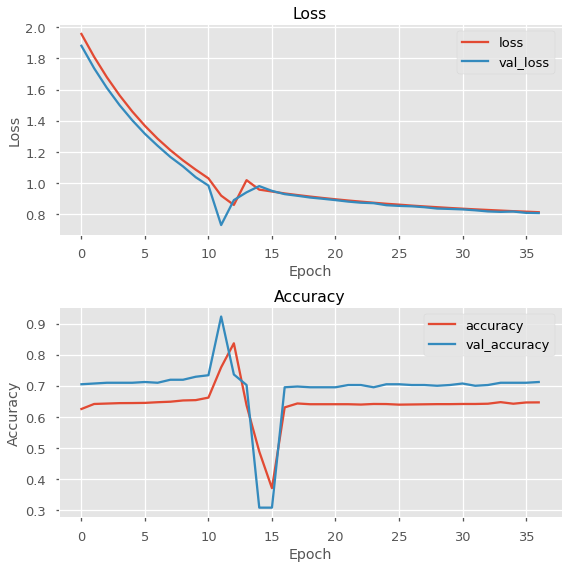

              precision    recall  f1-score   support

           0       0.58      0.14      0.22       322
           1       0.66      0.94      0.77       562

    accuracy                           0.65       884
   macro avg       0.62      0.54      0.50       884
weighted avg       0.63      0.65      0.57       884



In [ ]:
plot_history(history_v3)
y_pred = make_predictions(val_padded, model_v3)
print(classification_report(y_val, y_pred))

#### Version performed the strongest. I will look at version one (batch size = 50) compared to our og model five (batch size = 100)

#### Batch Size = 100
       precision    recall  f1-score   support

       0       0.95      0.98      0.96       322
       1       0.99      0.97      0.98       562

    accuracy                           0.97       884  





#### Batch Size = 50

                   precision  recall  f1-score   support

           0       0.97      0.95      0.96       322
           1       0.97      0.98      0.98       562

    accuracy                           0.97       884

#### Based on this I am determing Batch Size = 50 (Model_V1) to be superior. If there was business value in predicting the majority class (earn) with higher precision than the batch size=100 would be better. Model_V1 is more balanced.


  

# Final Model Evaluation
- To evaluate the final model I will inspect 
  - ROC 
  - Confusion Matrix


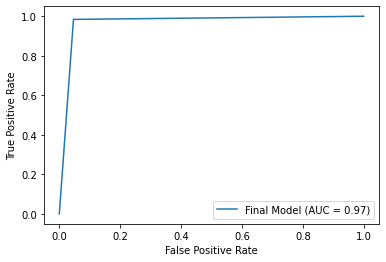

In [ ]:


y_pred = make_predictions(val_padded, model_v1)

#Code From https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_display_object_visualization.html#sphx-glr-auto-examples-miscellaneous-plot-display-object-visualization-py
fpr, tpr, _ = roc_curve(y_val, y_pred, pos_label=1)
auc = roc_auc_score(y_val, y_pred)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc,
                              estimator_name='Final Model').plot()

Text(0.5, 1.0, 'Confusion Matrix')

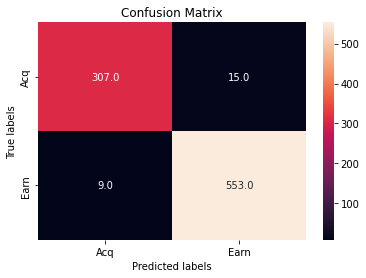

In [ ]:
ax = plt.subplot()
sns.heatmap(confusion_matrix(y_val, y_pred),annot=True, fmt=".1f",
            ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(['Acq', 'Earn']);
ax.yaxis.set_ticklabels(['Acq', 'Earn']);
ax.set_title('Confusion Matrix')

# Processing Functions
## Below are two functions to test the final model with unseen similar data. 
- process_file_data : This function can read a single file similar to the files in the reuters_data folder. The function reads the file, processes the data, and returns a prediction from my final model.
- process_raw_text : This function can take any string, process it, and return a prediction.

In [ ]:
def process_file_data(file):
  """
  IN: File to be processed

  OUT: Predicted Labels: 1 = Earn, 0 = Acq
  """
  titles = []
  texts = []
  topics = []
  #Read File
  soup = BeautifulSoup(open(file), features='lxml')
  #Acesss reuters data
  data_reuters = soup.find_all('reuters')
  for data in data_reuters:
      #Add title
      titles.append(data.find_all('title'))
      #Add Text
      texts.append(data.find_all('text'))
      topics.append(data.find_all('topics'))
  
  df = pd.DataFrame(columns=['Title','Text','Topics'])
  df.Title = titles
  df.Text = texts
  df.Topics = topics

  #First Scrub
  #Loop through each column and change the datatype to string
  for col in df.columns:
    df[col] = df[col].astype(str)
  #Loop through each row of the data frame
  for i in range(df.shape[0]):
    df.Title[i] = df.Title[i].replace('[','')
    df.Title[i] = df.Title[i].replace(']','')

    df.Text[i] = df.Text[i].replace(df.Title[i], '')

    df.Title[i] = df.Title[i].replace('<title>','')
    df.Title[i] = df.Title[i].replace('</title>','')

    df.Text[i] = df.Text[i].replace('\n', '')
    df.Text[i] = df.Text[i].replace('Reuter</text>]','')
    df.Text[i] = df.Text[i].replace('Reuter</text>]','')
    df.Text[i] = df.Text[i].replace('- </dateline>','')
    df.Text[i] = df.Text[i].replace('[<text><dateline>','')
    df.Text[i] = df.Text[i].replace('  ','')
    df.Text[i] = df.Text[i].replace('</dateline>','')
    df.Text[i] = df.Text[i].replace('</text>]','')

    df.Topics[i] = df.Topics[i].replace('[<topics><d>','')
    df.Topics[i] = df.Topics[i].replace('</d></topics>]','')
    df.Topics[i] = df.Topics[i].replace('</d><d>', '|')
    
  #Removes leading and trailing white spaces
  df.Text = df.Text.apply(lambda text: text.strip())
  #Removes all rows that do not contain topics and resets index
  df = df.loc[df.Topics != '[<topics></topics>]'].copy()
  df.reset_index(drop=True, inplace=True)


  df = df.loc[      
             (df.Topics == 'earn') |
             (df.Topics == 'acq') 
            ].copy()
  df['combined_text'] = df.Title + df.Text
  text_ = df.combined_text
  counter = counter_word(text_)
  num_words = len(counter)
  max_length = 200

  

  X = df['combined_text']


    #TOKENIZE
  #Removes Puncuation, and lowercases 
  tokenizer = Tokenizer(num_words=num_words, 
                        filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
  tokenizer.fit_on_texts(X)
  word_index = tokenizer.word_index
  #Sequencing
  test_sequences = tokenizer.texts_to_sequences(X)
  test_padded = pad_sequences(
      test_sequences, maxlen=max_length, padding="post", truncating="post"
  )



  
  y_pred = make_predictions(val_padded, model_v1)
  return y_pred




In [ ]:
def process_raw_text(text_):
  """
  IN: Text to be processed and labeled

  OUT: Predicted Labels: Earn |  Acq
  """
  
  counter = text_.split()
  num_words = len(counter)
  max_length = len(text_)
  X = pd.Series(text_)
  #TOKENIZE
  #Removes Puncuation, and lowercases 
  tokenizer = Tokenizer(num_words=num_words, 
                        filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
  tokenizer.fit_on_texts(X)
  word_index = tokenizer.word_index
  #Sequencing
  txt_sequence = tokenizer.texts_to_sequences(X)
  txt_padded = pad_sequences(
      txt_sequence, maxlen=max_length, padding="post", truncating="post"
  )

  y_pred = make_predictions(txt_padded, model_v1)
  if y_pred[0] == 1:
    return 'earn'
  else:
    return 'acq'
  return y_pred
  
   




In [ ]:
file = '/content/drive/MyDrive/reuters_data/reut2-003.sgm'
yo = process_file_data(file)

In [ ]:
txt = 'Hello and thank you for attending todays rigourous session of vivacous and exciting information'
process_raw_text(txt)

'acq'